<a href="https://colab.research.google.com/github/ms123321/Python-2021/blob/master/NASDAQ_predictor_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-alpha0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-alpha0


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
!pip install yfinance
!pip install quandl
import yfinance as yf
import quandl  


from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential 
from keras.layers import CuDNNLSTM

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

#csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [ ]:
#df = yf.download(tickers='BTC-USD', period = '1wk', interval = '1m')

In [ ]:
#df = df.sort_values('Datetime')

In [ ]:
QUANDL_API_KEY = 'LxKqezodnpFh1HWNNzgs'
quandl.ApiConfig.api_key = QUANDL_API_KEY 

# Set the start and end date
start_date = '1990-01-01'
end_date = '2018-03-01'

# Set the ticker name
ticker = 'TSLA'

# Feth the data
df = quandl.get('WIKI/'+ticker, 
                  start_date=start_date, 
                  end_date=end_date, 
                  api_key=QUANDL_API_KEY)

In [ ]:
df = df.sort_values('Datetime')

KeyError: ignored

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1997-05-16,22.38,23.75,20.50,20.75,1225000.0,0.0,1.0,1.865000,1.979167,1.708333,1.729167,14700000.0
1997-05-19,20.50,21.25,19.50,20.50,508900.0,0.0,1.0,1.708333,1.770833,1.625000,1.708333,6106800.0
1997-05-20,20.75,21.00,19.63,19.63,455600.0,0.0,1.0,1.729167,1.750000,1.635833,1.635833,5467200.0
1997-05-21,19.25,19.75,16.50,17.13,1571100.0,0.0,1.0,1.604167,1.645833,1.375000,1.427500,18853200.0
1997-05-22,17.25,17.38,15.75,16.75,981400.0,0.0,1.0,1.437500,1.448333,1.312500,1.395833,11776800.0


In [ ]:
df.shape

(5230, 12)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ec1243a50>,
      dtype=object)

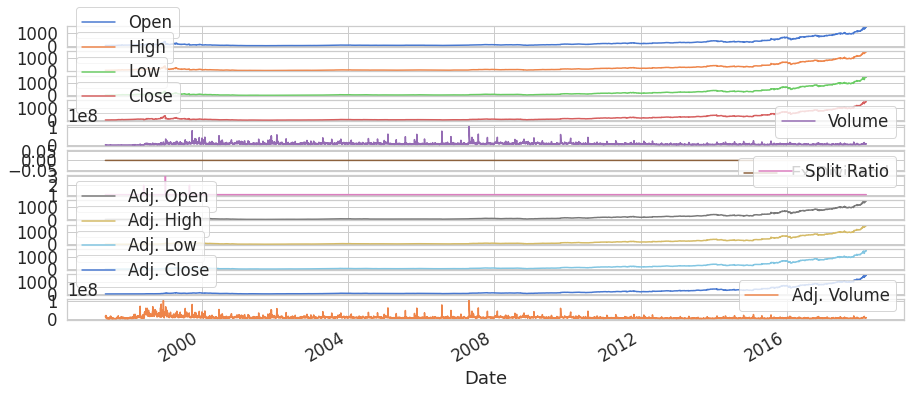

In [ ]:
#ax = df.plot(x=['Datetime'], y=['Close']);
#ax.set_xlabel("Datetime")
#ax.set_ylabel("Close Price (USD)")
df.plot(subplots=True, figsize=(15,6))

# Normalization

In [ ]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close.shape

(5230, 1)

In [ ]:
np.isnan(scaled_close).any()

False

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
X_train.shape

(4873, 99, 1)

In [ ]:
X_test.shape

(257, 99, 1)

# Model

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [ ]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
69/69 [==============================] - 20s 170ms/step - loss: 6.1992e-04 - val_loss: 0.0367
Epoch 2/50
69/69 [==============================] - 10s 151ms/step - loss: 0.0012 - val_loss: 0.0493
Epoch 3/50
69/69 [==============================] - 11s 153ms/step - loss: 7.2260e-04 - val_loss: 0.0360
Epoch 4/50
69/69 [==============================] - 10s 151ms/step - loss: 8.4251e-04 - val_loss: 0.0541
Epoch 5/50
69/69 [==============================] - 10s 151ms/step - loss: 0.0010 - val_loss: 0.0448
Epoch 6/50
69/69 [==============================] - 10s 151ms/step - loss: 0.0013 - val_loss: 0.0495
Epoch 7/50
69/69 [==============================] - 10s 151ms/step - loss: 0.0013 - val_loss: 0.0465
Epoch 8/50
69/69 [==============================] - 10s 151ms/step - loss: 0.0014 - val_loss: 0.0591
Epoch 9/50
69/69 [==============================] - 11s 154ms/step - loss: 0.0021 - val_loss: 0.0527
Epoch 10/50
69/69 [==============================] - 10s 151ms/step - loss: 0.0

In [ ]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 166ms/step - loss: 3.5384e-04


0.00035384399234317243

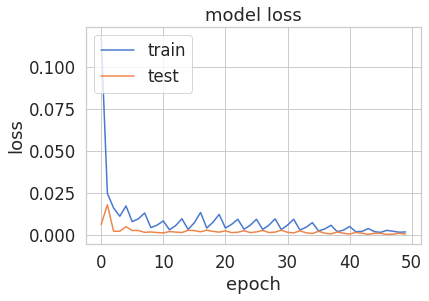

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

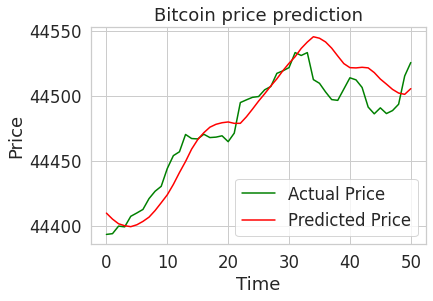

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();